In [2]:
# jupyter-notebookのcellの幅を広げる
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100%!important;}</style>"))

In [3]:
import numpy as np
import pandas as pd
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns

# 音声解析用のライブラリ
import scipy.signal as ss
import librosa
import librosa.display
import IPython.display as ipd #jupyter-notebook上で音声再生import matplotlib.pyplot as plt

# ユーティリティメソッドの読み込み 
from Util import NormalizeHorizontalDirection 

# jupyter-notebook上に図を出力するマジックコマンド
%matplotlib inline

Using TensorFlow backend.


In [12]:
from joblib import Parallel, delayed
from time import time

In [9]:
# 作業ディレクトリの設定
os.chdir("/home/taichi/DataAnalysis/05_NTT_corevo")

In [11]:
# 音声データ（mp3形式）の読み込み
# sr : sampling rate (単位時間当たりの標本数)1/s
#  x: audio timeseries

# 音声データのパスを指定
audio_path = "01_input/ntt_corevo/train/0002f1cd968ca78ada9e1c7037224773.wav"

#　音声データからサンプリングレートと音圧を取得
x,sr = librosa.load(audio_path)

In [12]:
# サンプリングレートの説明
print(sr)

22050


In [13]:
# 音声データの形状
# 1次元データ
print(x.shape)

(68576,)


In [14]:
# 音声データを再生
# IPython.display を用いると、jupyter-notebook上で音声を再生することができる
ipd.Audio(x, rate=sr) # load a NumPy array

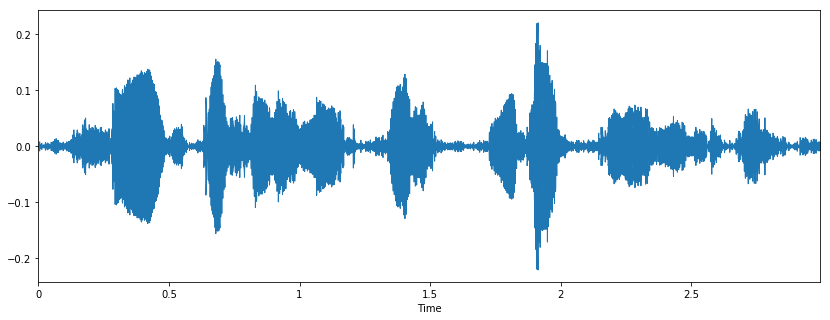

In [15]:
# 本解析では3 秒分の音声を入力する
frame_bin = int(sr * (10 ** (-3))) # 1ms当たりに音声を音声を計測した数。
# 抽出する音声の区間。lb(ms)～ub(ms)の音声を抽出
lb = 0
ub = 3000

# 音声を抽出
extracted_x = x[frame_bin * lb:frame_bin * ub]

# プロット 
plt.figure(figsize = (14,5))
librosa.display.waveplot(extracted_x,sr=sr)

In [16]:
# 音声データからの特徴抽出
# 本解析では音声データの特徴量として、スペクトログラムを用いる
# オプションの参考ページ
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html 

f, t, Zxx = ss.stft(extracted_x,fs = sr,
                    window = ss.get_window("hamming",frame_bin * 25),# 25ms
                    nperseg = frame_bin * 25, 
                    noverlap = frame_bin * 15,# 音声波形の抽出に、15msずつovarlap    
                    nfft = 1024 # ここが1024で動くのがよくわからん。
                   )

# スペクトログラムは、フーリエ変換のパワースペクトルの絶対値を用いる
spectral = np.abs(Zxx)

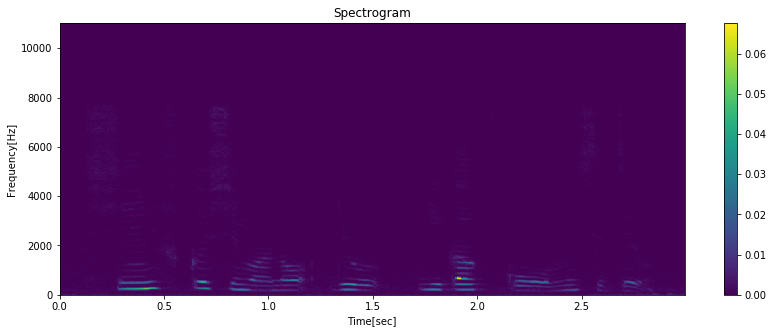

In [17]:
# スペクトログラムをプロット
plt.figure(figsize=(14,5))
plt.title('Spectrogram')
plt.pcolormesh(t,f,spectral,vmin = 0)
plt.ylabel("Frequency[Hz]")
plt.xlabel("Time[sec]")
plt.colorbar()
plt.show()

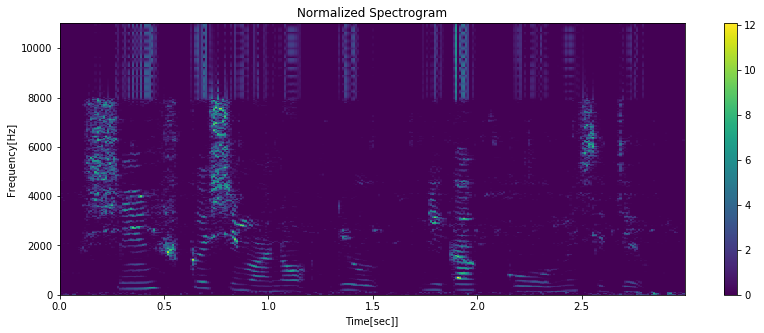

In [18]:
# 周波数方向にスペクトログラムを正規化
spectral_norm = NormalizeHorizontalDirection(spectral)

# 正規化したスペクトログラムをプロット
plt.figure(figsize = (14,5))
plt.title('Normalized Spectrogram')
plt.pcolormesh(t,f,spectral_norm,vmin = 0)
plt.ylabel("Frequency[Hz]")
plt.xlabel("Time[sec]]")
plt.colorbar()
plt.show()

In [19]:
# データのラベル数を集計

In [20]:
anno = pd.read_csv("01_input/ntt_corevo/class_train.tsv",
                  delimiter = "\t",
                  names = ("filename","class"))

In [21]:
anno.head()

,filename,class
0,0002f1cd968ca78ada9e1c7037224773,MA_CH
1,0003747ec9268461d4cbb9e1b86e9663,FE_AD
2,0003b32f378b001f0f73bf0981da8773,MA_CH
3,0004ab975bf8b59e1b19f2b7b6d1548b,MA_CH
4,0005678b57ca265a65f8ef0cc7481277,MA_AD


In [22]:
# データ数
anno.shape[0]

37806

In [23]:
# ラベル数 ラベル数は全ラベルで大体同じくらい
anno.groupby("class").describe()

filename                                              
         count unique                               top freq
class                                                       
FE_AD     6985   6985  fafe393b7410882046df23bc35e7988d    1
FE_CH     6853   6853  bf37827fb528e1f684ed86cff5d01529    1
FE_EL     5430   5430  57ee30584ec96a25d2becb583e11de33    1
MA_AD     6627   6627  75485e69fb065bc0ef026a401d5ed73e    1
MA_CH     7553   7553  c578184961d40cb2a475aabdee4d6343    1
MA_EL     4358   4358  e1669ff35dbc4a0bd192c4fda6a9e9f4    1

In [24]:
anno["filepath"] = "01_input/ntt_corevo/train/" + anno["filename"] + ".wav"

In [15]:
from joblib import Parallel, delayed
from time import time

def extract_time(tmp_a):
    x,sr = librosa.load(tmp_a["filepath"])
    time = x.shape[0]/sr 
    return time

In [14]:
NJOBS = 12
time_dist = Parallel(n_jobs=NJOBS)( [delayed(extract_time)(v) for i,v in anno.iterrows()] )

NameError: name 'anno' is not defined

In [45]:
anno["time"] = time_dist

In [63]:
anno.to_csv("03_work/train_time_distribution.csv",index = False)

In [46]:
anno.head()

,filename,class,filepath,time
0,0002f1cd968ca78ada9e1c7037224773,MA_CH,01_input/ntt_corevo/train/0002f1cd968ca78ada9e...,3.110023
1,0003747ec9268461d4cbb9e1b86e9663,FE_AD,01_input/ntt_corevo/train/0003747ec9268461d4cb...,1.510023
2,0003b32f378b001f0f73bf0981da8773,MA_CH,01_input/ntt_corevo/train/0003b32f378b001f0f73...,8.240000
3,0004ab975bf8b59e1b19f2b7b6d1548b,MA_CH,01_input/ntt_corevo/train/0004ab975bf8b59e1b19...,2.320000
4,0005678b57ca265a65f8ef0cc7481277,MA_AD,01_input/ntt_corevo/train/0005678b57ca265a65f8...,2.130023


In [50]:
anno.describe()

,time
count,37806.000000
mean,3.074654
std,1.815108
min,0.320000
25%,2.060000
50%,2.530023
75%,3.350023
max,46.870023


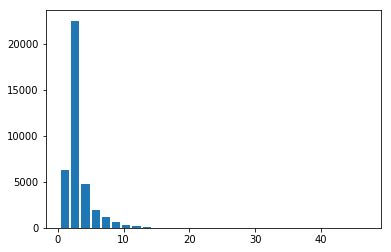

In [53]:
# 学習データの音声時間のヒストグラムを作成
bins = 30
plt.hist(anno["time"],bins = bins,rwidth = 0.8)
plt.show()

In [52]:
anno.query('time > 20')

,filename,class,filepath,time
6946,2f308660cde1244209ee8b28b4502c65,FE_EL,01_input/ntt_corevo/train/2f308660cde1244209ee...,20.860000
8602,3a5c89b172235ee5c45bcb9b5a134971,FE_AD,01_input/ntt_corevo/train/3a5c89b172235ee5c45b...,46.870023
23759,a0d36948e9609619627aa64941f11a9b,FE_EL,01_input/ntt_corevo/train/a0d36948e9609619627a...,33.840000
28930,c41966e38e71a1b9e1dd39a5e2d7093f,FE_EL,01_input/ntt_corevo/train/c41966e38e71a1b9e1dd...,33.840000


In [ ]:
# 年代毎の音声の長さ
# 性別毎の音声の長さ

In [36]:
ipd.Audio(x, rate=sr)

In [10]:
# テストデータに対するEDA
import glob
test_path = glob.glob("01_input/ntt_corevo/test/*wav") 

In [16]:
test_anno = pd.DataFrame({"filepath":test_path})
test_anno["filename"] = test_anno["filepath"].str.replace(".wav$","")\
                                             .str.replace("01_input/ntt_corevo/test/","")

NJOBS = 12
test_time_dist = Parallel(n_jobs=NJOBS)([delayed(extract_time)(v) for i,v in test_anno.iterrows()] )

In [17]:
test_anno["time"] = test_time_dist

In [18]:
test_anno.to_csv("03_work/test_time_distribution.csv",index = False)

In [66]:
test_anno.describe()

,time
count,17888.000000
mean,2.999011
std,1.750643
min,0.420000
25%,2.020000
50%,2.480000
75%,3.270023
max,18.350023


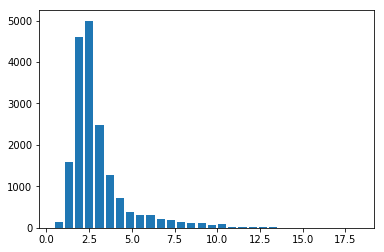

In [65]:
# 音声時間のヒストグラムを作成
bins = 30
plt.hist(test_anno["time"],bins = bins,rwidth = 0.8)
plt.show()